# Testing DEMV on _Law School Admissions_ (LAW) dataset

- Unprivileged group: `gender=1`
- sex: 1 female, 0 male

In [30]:
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
#from sklearnex import patch_sklearn
#patch_sklearn()

from fairlearn.reductions import ExponentiatedGradient, BoundedGroupLoss, ZeroOneLoss

import matplotlib.pyplot as plt
import seaborn as sns

from utils import *
from demv import DEMV

import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')


In [31]:
data = pd.read_csv('data/bar_pass_prediction.csv', index_col='Unnamed: 0')
col_to_drop = ['ID', 'decile1b', 'decile3', 'decile1', 'cluster', 'bar1', 'bar2',
               'sex', 'male', 'race1', 'race2', 'other', 'asian', 'black', 'hisp', 'bar', 'index6040', 'indxgrp', 'indxgrp2', 'dnn_bar_pass_prediction', 'grad', 'bar1_yr', 'bar2_yr', 'ugpa']
data.drop(col_to_drop, axis=1, inplace=True)
data.loc[data['Dropout'] == 'NO', 'Dropout'] = 0
data.loc[data['Dropout'] == 'YES', 'Dropout'] = 1
data.dropna(inplace=True)
data.loc[data['gender']=='female', 'gender'] = 1
data.loc[data['gender'] == 'male', 'gender'] = 0
data.loc[data['race']==7.0, 'race'] = 0
data.loc[data['race'] != 0, 'race'] = 1
data['gpa'] = pd.qcut(data['gpa'], 3, labels=['a','b','c'])
enc = LabelEncoder()
data['gpa'] = enc.fit_transform(data['gpa'].values)
data


,race,lsat,zfygpa,DOB_yr,zgpa,fulltime,fam_inc,age,gender,parttime,Dropout,pass_bar,tier,gpa
0,0.0,44.0,1.33,69.0,1.88,1.0,5.0,-62.0,1,0.0,0,1.0,4.0,2
1,0.0,29.0,-0.11,69.0,-0.57,1.0,4.0,-62.0,1,0.0,0,1.0,2.0,2
2,0.0,36.0,-0.64,65.0,-1.12,1.0,1.0,-58.0,0,0.0,0,1.0,3.0,2
3,0.0,39.0,0.34,58.0,-0.49,1.0,4.0,-51.0,0,0.0,0,1.0,3.0,2
4,0.0,48.0,1.02,68.0,0.76,1.0,4.0,-61.0,0,0.0,0,1.0,5.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22402,1.0,26.5,-0.58,64.0,-1.49,1.0,2.0,-62.0,0,0.0,0,0.0,1.0,0
22403,1.0,19.7,-0.64,64.0,-1.36,1.0,3.0,-57.0,0,0.0,0,0.0,1.0,0
22404,1.0,36.0,0.41,66.0,0.80,2.0,3.0,-59.0,0,1.0,0,1.0,3.0,0
22405,0.0,44.0,1.88,58.0,1.42,2.0,3.0,-51.0,0,1.0,0,1.0,3.0,0


In [32]:
protected_group = {'gender': 1}
label = 'gpa'
sensitive_features=['gender']
positive_label = 2

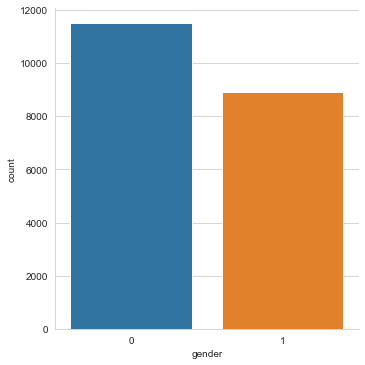

In [33]:
sns.catplot(data=data, x='gender', kind='count')
plt.show()

## Bias Metrics

### Logistic regression

In [34]:
pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        (
            "classifier",
            LogisticRegression(),
        ),
    ]
)

In [35]:
model, lr_metrics = cross_val(pipeline, data, label, protected_group, sensitive_features=sensitive_features, positive_label=positive_label)
print_metrics(lr_metrics)

Statistical parity:  0.226  +-  0.02
Disparate impact:  0.56  +-  0.033
Zero one loss:  0.036  +-  0.016
F1 score:  0.449  +-  0.011
Accuracy score:  0.521  +-  0.01


## DEMV Metrics

In [36]:
demv = DEMV(round_level=1)
demv_data = data.copy()

### Logistic regression

In [37]:
model, lr_demv = cross_val(deepcopy(pipeline), demv_data, label, protected_group, sensitive_features=sensitive_features, debiaser=demv, positive_label=2)
print_metrics(lr_demv)

Statistical parity:  0.099  +-  0.021
Disparate impact:  0.773  +-  0.044
Zero one loss:  0.037  +-  0.021
F1 score:  0.445  +-  0.012
Accuracy score:  0.521  +-  0.012


## Fairlearn Exponentiated Gradient

In [38]:
fl_data = data.copy()
const = BoundedGroupLoss(ZeroOneLoss(), upper_bound=0.1)

In [39]:
lr_model = ExponentiatedGradient(
    pipeline, const, sample_weight_name="classifier__sample_weight")
lr_model, lr_metrics = cross_val(lr_model, fl_data, label, protected_group, sensitive_features=sensitive_features, exp=True, positive_label=2)


In [40]:
print_metrics(lr_metrics)

Statistical parity:  0.188  +-  0.022
Disparate impact:  0.61  +-  0.035
Zero one loss:  0.042  +-  0.022
F1 score:  0.457  +-  0.009
Accuracy score:  0.522  +-  0.009


## DEMV Evaluation

In [41]:
demv.get_iters()

355

In [42]:
metrics = eval_demv(200, demv.get_iters(), data.copy(), pipeline, label, protected_group, sensitive_features, positive_label=2)

In [43]:
df = prepareplots(metrics,'lawSinglevar')
iters = df['stop'].iloc[-1]

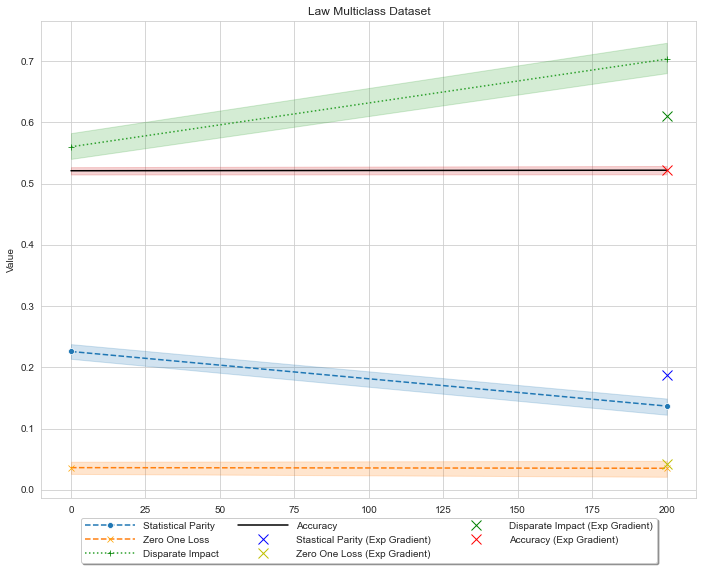

In [44]:
points = preparepoints(lr_metrics, iters)

plot_metrics_curves(df, points, 'Law Multiclass Dataset')


In [45]:
unprivpergentage(data,protected_group, demv.get_iters())

Dataset size: 20427
Unprivileged group size: 8926
Percentage of unprivileged group: 43.69706760659911
Number of iterations: 355
